# Notebook Objectives

In this notebooks, we'll go through the main behavioral analysis results.

Results include:
* ?
* ?

# Tutorial 2: Convolutional Neural Networks

**Week 1, Day 5: Deep Learning**

**By Neuromatch Academy**

**Content creators**: Jorge A. Menendez, Carsen Stringer

**Content reviewers**: Roozbeh Farhoodi,  Madineh Sarvestani, Kshitij Dwivedi, Spiros Chavlis, Ella Batty, Michael Waskom

**Production editors:** Spiros Chavlis

---
# Setup


In [17]:
# @title Imports
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, permutation_test_score, cross_validate

import statsmodels.api as sm
from statsmodels.formula.api import glm
from scipy.optimize import curve_fit

from popy.io_tools import load_behavior, load_simulation
from popy.plotting.plotting_tools import *
from popy.behavior_data_tools import *
from behav_analysis_tools import *
from popy.config import COLORS

# fontsize 12
plt.rcParams.update({'font.size': 8})


In [1]:
##% plotting
def plot_glm_weights(df_res, plot_significance=False, title=None, saveas=None):
    # Plot the results
    cm = 1/2.54  # centimeters in inches
    fig, ax = plt.subplots()
    fig.set_size_inches(10*cm, 7*cm)
    
    if title is not None:
        plt.suptitle(title)

    # scale weights for both monkeys by dividing with the maximum absolute value
    #df_res['coeffs'] = df_res['coeffs'] / df_res.groupby('monkey')['coeffs'].transform('max')

    legend_elements = []  # Store legend elements for each monkey

    # Create scatter plot for each monkey
    for monkey, group in df_res.groupby('monkey'):
        # Convert variable names to numeric x-positions
        x_positions = [list(df_res['variable'].unique()).index(var) for var in group['variable']]
        
        # Get color from COLORS dictionary using monkey key
        current_color = COLORS[monkey.split('_')[-1]]
        linestyle = 'dashdot' if monkey.split('_')[0] == 'simulation' else 'solid'
        alpha = 0.5 if monkey.split('_')[0] == 'simulation' else 1
        
        # Plot points with different fill styles based on significance
        significant = group['pvalue'] < 0.01

        # fit exponential curve of c(a(1-a)^t)
        x = np.arange(0, len(group['coeffs']))
        y = group['coeffs']
        popt, pcov = curve_fit(lambda x, c, a: c * (a * (1 - a) ** x), x, y)
        print(f'{monkey}: c={popt[0]:.2f}, a={popt[1]:.2f}')
        ax.plot(x, popt[0] * (popt[1] * (1 - popt[1]) ** x), color='red', linestyle='--', alpha=0.5)
        
        # Plot significant points (filled)
        ax.scatter(
            [x for x, sig in zip(x_positions, significant) if sig],
            [y for y, sig in zip(group['coeffs'], significant) if sig],
            color=current_color,
            s=30,
            marker='o',
            label=f'{monkey.upper()}, alpha={popt[1]:.2f}',
            alpha=alpha,
        )
        
        # Plot non-significant points (empty)
        ax.scatter(
            [x for x, sig in zip(x_positions, significant) if not sig],
            [y for y, sig in zip(group['coeffs'], significant) if not sig],
            color=current_color,
            s=30,
            marker='o',
            facecolors='none',
            alpha=alpha
        )
        
        # Add lines connecting points
        ax.plot(x_positions, group['coeffs'], color=current_color, alpha=0.5, linestyle=linestyle)

        '''# Create legend elements for this monkey
        legend_elements.extend([
            plt.scatter([], [], color=current_color, s=30, marker='o', label=f'{monkey.upper()}'),
        ])'''

    # Add significance markers to legend
    plt.scatter([], [], color='gray', s=30, marker='o', label='p < 0.01'),
    plt.scatter([], [], color='gray', s=30, marker='o', facecolors='none', label='n.s.')

    # add zero baseline
    #ax.axhline(0, color='black', linewidth=0.5)
    #ax.set_ylim(0, 1.1)

    # Plot settings
    ax.set_ylabel('Reward history weight')
    ax.set_xlabel('Trials in past')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)

    # Set x-ticks with t-n format
    ax.set_xticks(range(len(df_res['variable'].unique())))
    ax.set_xticklabels([f't-{i+1}' for i in range(len(df_res['variable'].unique()))])

    # Add legend with both monkey names and significance indicators
    ax.legend(frameon=False)

    plt.tight_layout()
    
    if saveas is not None:
        plt.savefig(saveas, dpi=300, bbox_inches='tight', transparent=True)

        
def plot_proba_switch(df_proba_switch):
    linestyles = {'all_trials': '-', 
                  'exploratory_trials': '--',
                  'exploitatory_trials': ':',
                  'exploitatory_trials_best': '-.',
                  'exploitatory_trials_worst': '-'}

    fig, axs = plt.subplots(3, 1, figsize=(4, 10), sharex=True, sharey=True)

    ax = axs[0]
    # Create the lineplot
    data_curr = df_proba_switch[df_proba_switch['data'] == 'all_trials']
    sns.lineplot(x='history', y='proba_switch', hue='monkey', data=data_curr, marker='o', ax=ax,
     palette=COLORS, markers=True, markersize=10)
    ax.legend(title='Monkey', bbox_to_anchor=(1, 1), loc='upper left')

    ax = axs[1]
    # Create the lineplot for Ka
    data_curr = df_proba_switch[df_proba_switch['monkey'] == 'ka']
    sns.lineplot(x='history', y='proba_switch', hue='data', data=data_curr, marker='o', ax=ax,
                palette={'all_trials': COLORS['ka'], 'exploratory_trials': COLORS['ka'], 
                'exploitatory_trials': COLORS['ka'], 'exploitatory_trials_worst': COLORS['ka']},
                style='data', linestyle='-', markers=True, markersize=10)
    ax.legend(title='Monkey Ka', bbox_to_anchor=(1, 1), loc='upper left')

    ax = axs[2]
    # Create the lineplot for Po
    data_curr = df_proba_switch[df_proba_switch['monkey'] == 'po']
    sns.lineplot(x='history', y='proba_switch', hue='data', data=data_curr, marker='o', ax=ax,
                palette={'all_trials': COLORS['po'], 'exploratory_trials': COLORS['po'], 
                'exploitatory_trials': COLORS['po'], 'exploitatory_trials_worst': COLORS['po']},
                style='data', linestyle='-', markers=True, markersize=10)
    ax.legend(title='Monkey Po', bbox_to_anchor=(1, 1), loc='upper left')

    # Customize the plot
    for ax in axs:
        ax.set_xticks(range(0, 8))
        ax.set_xticklabels([f'{i:03b}\n' for i in range(8)])
        ax.set_xlabel('')
        ax.set_ylabel('Probability of switching')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    #plt.tight_layout()
    plt.show()

In [3]:
# @title Helper Functions
def get_proba_switch(behav_original):
    behav = behav_original.copy()

    # Create a list to store the results
    exploration_limit = 6
    results = []

    history = np.stack(behav['history_of_feedback'].values)[:, :3]
    # Convert binary rows to decimal values
    history_ranked = history.dot(2**np.arange(history.shape[1])[::-1])
    behav['history_of_feedback_ranked'] = history_ranked

    # Calculate the probability of switching for each history
    for monkey, data_monkey in behav.groupby('monkey'):
        for i in range(1000):  # Repeat the random undersampling 1000 times
            # Randomly undersample the data
            data_monkey_sampled = random_undersampling(data_monkey, 'switch')

            # Calculate the probability of switching for each history
            for hist, data in data_monkey_sampled.groupby('history_of_feedback_ranked'):
                # Filter out the first 3 trials after a switch, i.e. only consider trials from the same target
                data = data[data['trials_since_switch'] >= 3]

                # Calculate the probability of switching for all trials
                proba_switch = np.mean(data['switch'] == True)

                # Calculate the probability of switching for exploratory trials (i.e. where trials_since_switch < 6)
                data_temp_exploratory = data[data['trials_since_switch'] < exploration_limit]
                proba_switch_exploratory = np.mean(data_temp_exploratory['switch'] == True)
                
                # Calculate the probability of switching for exploitatory trials (i.e. where trials_since_switch >= 6) -- all targets
                data_temp_exploitatory = data[data['trials_since_switch'] >= exploration_limit]
                proba_switch_exploitatory = np.mean(data_temp_exploitatory['switch'] == True)
            
                results.append({'permutation': i, 'monkey': monkey, 'history': hist, 'proba_switch': proba_switch, 'data': 'all_trials', 'n_trials': len(data)})
                results.append({'permutation': i, 'monkey': monkey, 'history': hist, 'proba_switch': proba_switch_exploratory, 'data': 'exploratory_trials', 'n_trials': len(data_temp_exploratory)})
                results.append({'permutation': i, 'monkey': monkey, 'history': hist, 'proba_switch': proba_switch_exploitatory, 'data': 'exploitatory_trials', 'n_trials': len(data_temp_exploitatory)})

    # Convert the list of results to a DataFrame
    df_proba_switch = pd.DataFrame(results)

    # get the mean proba_switch and mean n_trials of each permutation for each (monkey, history, data) group
    df_proba_switch = df_proba_switch.groupby(['monkey', 'history', 'data']).agg({'proba_switch': 'mean', 'n_trials': 'mean'}).reset_index()

    return df_proba_switch

def random_undersampling(df, target_column):

    # Get the number of samples for the minority class
    n_samples = df[target_column].value_counts().min()

    # Get the indices of the minority class
    minority_indices = df[df[target_column] == 1].index

    # Get the indices of the majority class
    majority_indices = df[df[target_column] == 0].index

    # Randomly sample the majority class
    random_majority_indices = np.random.choice(majority_indices, n_samples, replace=False)

    # Concatenate the minority indices with the sampled majority indices
    under_sample_indices = np.concatenate([minority_indices, random_majority_indices])

    # Get the under-sampled DataFrame
    df_under_sampled = df.loc[under_sample_indices]

    return df_under_sampled


In [4]:
# @title Data retrieval and loading
def get_data_custom():
    behav = load_behavior()
    behav = drop_time_fields(behav)

    simulation_ka = load_simulation(monkey='ka')
    simulation_ka.drop(columns=['value_function'], inplace=True)
    simulation_po = load_simulation(monkey='po')
    simulation_po.drop(columns=['value_function'], inplace=True)

    behav = pd.concat([behav, simulation_ka, simulation_po], ignore_index=True)

    behav = add_history_of_feedback(behav, one_column=True, num_trials=5)
    behav = add_history_of_feedback(behav, one_column=False, num_trials=8)
    behav = add_switch_info(behav, add_trials_since_switch=True)
    behav = add_phase_info(behav, exploration_limit=6, transition_limit=0)

    behav = behav.dropna()

    return behav

In [5]:
# @title GLM model
def fit_glm(behav, predictors):
    # prepare data: get predictors, target (switch), and monkey (to handlem them separately)
    df_glm = behav[predictors + ['switch', 'monkey']].copy()
    df_glm['switch'] = -1 * df_glm['switch'] + 1
    df_glm['switch'] = df_glm['switch'].astype(int)  # switch column to int and flip sign
    df_glm = random_undersampling(df_glm, 'switch')  # balance switch and no-switch trials
    df_glm = sm.add_constant(df_glm)  # add constant
    df_glm = df_glm.sample(frac=1).reset_index(drop=True)  # shuffle the data

    # Define the formula
    formula = 'switch ~ ' + ' + '.join(predictors)

    # Fit the model for each monkey
    res = []
    accs = {}
    for monkey, data in df_glm.groupby('monkey'):  # TODO we do not need the statsmodels approach if we find a normal way to compute statistical significances of the weights (which we should od in fact with permutation testing i think)
        # Fit GLM on full data
        model = sm.formula.glm(formula=formula, data=data, family=sm.families.Binomial())  
        result = model.fit()
                
        # accuracy and roc-auc w. sklearn
        model = LogisticRegression(fit_intercept=True, max_iter=1000, penalty=None)
        # cross-validation
        cv_model = cross_validate(model, data[predictors], data['switch'], cv=10, return_estimator=True, scoring='accuracy')
        coefs = pd.DataFrame([est.coef_[0] for est in cv_model['estimator']], columns=predictors)
        scores_cv = cv_model['test_score']

        # permutation test
        score_perm, permutated_scores, pvalue = permutation_test_score(model, data[predictors], data['switch'], cv=10, n_permutations=1000, n_jobs=-1, scoring='accuracy')

        print(f'Monkey: {monkey}, CV accuracy: {scores_cv.mean():.2f} +/- {scores_cv.std():.2f}, Permutation test p-value: {pvalue:.2f}')
        accs[monkey] = scores_cv.mean()

        
        # Store the results
        # add statsmodels results
        for k in result.params.keys():
            if k != 'Intercept':
                res.append({'monkey': monkey, 
                            'variable': k,  # predictor, e.g. R_1
                            'coeffs': result.params[k],  # coefficient of statmodels
                            'coeffs_cv': coefs[k].mean(),  # coefficient of sklearn CV (mean of K folds)
                            'coeffs_cv_std': coefs[k].std(),  # std of the coefficient of sklearn CV (std of K folds)'''
                            #'tvalue': result.tvalues[k], 
                            'pvalue': result.pvalues[k],  # p-value of that coeff, selon statsmodels
                            'if_significant': result.pvalues[k] < 0.05,  # if the p-value is significant
                        })

    df_res = pd.DataFrame(res)

    return df_res, accs

---
# Get data

In [6]:
behav = get_data_custom()
behav.columns

Index(['monkey', 'session', 'trial_id', 'block_id', 'best_target', 'target',
       'feedback', 'history_of_feedback', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5',
       'R_6', 'R_7', 'R_8', 'T_1', 'T_2', 'T_3', 'T_4', 'T_5', 'T_6', 'T_7',
       'T_8', 'switch', 'trials_since_switch', 'phase'],
      dtype='object')

In [7]:
# count monkey=='ka, 'po', and 'simulation'
behav['monkey'].value_counts()

monkey
simulation_ka    23867
ka               23333
simulation_po    15175
po               14578
Name: count, dtype: int64

---
# Section 1: Switching is history dependent

The model here is:

$$
\text{Switch} = \sigma(\beta_0 + \beta_1 R_{t-1} + \beta_2 R_{t-2} + \ldots + \beta_N R_{t-N})
$$

where $\sigma$ is the sigmoid function.

## Outcome history

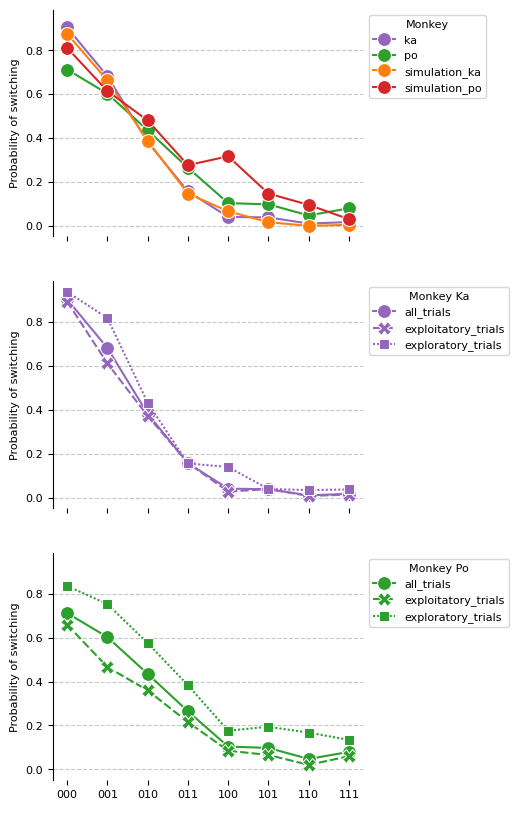

In [8]:
# Calculate the probability of switching for each history
df_proba_switch = get_proba_switch(behav)

# Display the results
plot_proba_switch(df_proba_switch)

## Logistic regression

In [9]:
behav

,monkey,session,trial_id,block_id,best_target,target,feedback,history_of_feedback,R_1,R_2,...,T_2,T_3,T_4,T_5,T_6,T_7,T_8,switch,trials_since_switch,phase
8,ka,010720,8,0,2,2.0,1.0,"[1, 1, 0, 1, 0]",1.0,1.0,...,2.0,3.0,3.0,1.0,1.0,3.0,3.0,0.0,2,search
9,ka,010720,9,0,2,2.0,1.0,"[1, 1, 1, 0, 1]",1.0,1.0,...,2.0,2.0,3.0,3.0,1.0,1.0,3.0,0.0,3,search
10,ka,010720,10,0,2,2.0,1.0,"[1, 1, 1, 1, 0]",1.0,1.0,...,2.0,2.0,2.0,3.0,3.0,1.0,1.0,0.0,4,search
11,ka,010720,11,0,2,2.0,1.0,"[1, 1, 1, 1, 1]",1.0,1.0,...,2.0,2.0,2.0,2.0,3.0,3.0,1.0,0.0,5,search
12,ka,010720,12,0,2,2.0,1.0,"[1, 1, 1, 1, 1]",1.0,1.0,...,2.0,2.0,2.0,2.0,2.0,3.0,3.0,0.0,6,repeat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78272,simulation_po,-1,15178,376,3,3.0,1.0,"[0, 1, 1, 1, 0]",0.0,1.0,...,3.0,3.0,3.0,3.0,3.0,1.0,1.0,0.0,6,repeat
78273,simulation_po,-1,15179,376,3,3.0,0.0,"[1, 0, 1, 1, 1]",1.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,1.0,0.0,7,repeat
78274,simulation_po,-1,15180,376,3,3.0,0.0,"[0, 1, 0, 1, 1]",0.0,1.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,8,repeat
78275,simulation_po,-1,15181,376,3,3.0,0.0,"[0, 0, 1, 0, 1]",0.0,0.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,0.0,9,repeat


In [10]:
# Fit the GLM
'''predictors = ['history_of_feedback_ranked', 'trials_since_switch', 'target', 'RT', 'best_target', 'trial_id']
df_res = fit_glm(behav, predictors=predictors)

# Plot the results
plot_glm_weights(df_res)'''

"predictors = ['history_of_feedback_ranked', 'trials_since_switch', 'target', 'RT', 'best_target', 'trial_id']\ndf_res = fit_glm(behav, predictors=predictors)\n\n# Plot the results\nplot_glm_weights(df_res)"

ka: c=10.41, a=0.43
po: c=5.51, a=0.43
simulation_ka: c=9.98, a=0.45
simulation_po: c=5.82, a=0.38


,monkey,variable,coeffs,coeffs_cv,coeffs_cv_std,pvalue,if_significant
0,ka,R_1,4.460009,4.423434,0.040678,1.082001e-211,True
1,ka,R_2,2.611635,2.611209,0.019435,2.876474e-283,True
2,ka,R_3,1.520802,1.522653,0.017117,1.528048e-138,True
3,ka,R_4,0.786343,0.786434,0.025989,6.930564e-41,True
4,ka,R_5,0.454848,0.455915,0.018083,7.733048e-15,True
5,ka,R_6,0.213146,0.216530,0.018631,2.714704e-04,True
6,ka,R_7,0.032294,0.034982,0.025031,5.821056e-01,False
7,ka,R_8,0.006075,0.009641,0.022680,9.173192e-01,False
8,po,R_1,2.384710,2.388608,0.026258,0.000000e+00,True
9,po,R_2,1.352388,1.352225,0.008465,1.337925e-161,True


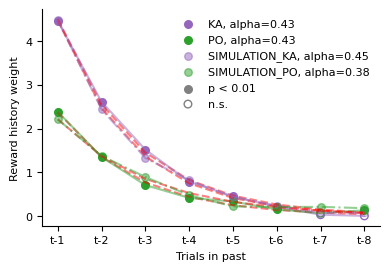

In [ ]:
# Fit the GLM
predictors = ['R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8']#, 'trials_since_switch', 'target', 'RT', 'best_target', 'trial_id']
df_res, scores = fit_glm(behav, predictors=predictors)

# Plot the results
saveas = None# 'figs/glm_weights.svg'
plot_glm_weights(df_res,
                 plot_significance=True, 
                 title=None, #f'GLM weights\nMonkey: Ka, ROC-AUC: {scores["ka"].mean():.2f}\nMonkey Po, ROC-AUC: {scores["po"].mean():.2f}',
                 saveas=saveas)

df_res